In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import fnmatch
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive
drive.mount('/content/drive')
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import backend as tf_keras_backend

tf_keras_backend.set_image_data_format('channels_last')
tf_keras_backend.image_data_format()
import glob

Mounted at /content/drive


In [ ]:

from skimage.filters import sobel
from skimage.util import invert
from skimage.color import rgb2gray
imgs=[]
ims=[]
img_list = sorted(glob.glob('/content/drive/MyDrive/Colab_Notebooks/Nega/line-images/*.PNG'))
for i, img_path in enumerate(img_list):
  ims = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  th2 = cv2.adaptiveThreshold(ims,170,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,35,25)
  imgs.append(th2)

In [ ]:
dim=(256, 48)
def im_resize(input_image):
    #f=cv2.transpose(input_image)
    im_resize=cv2.resize(input_image, dim)
    return im_resize

In [ ]:
train = []
valid = []

for i in range(len(imgs)):
    image = im_resize(imgs[i])
    image = image/255.
    if i%10 == 0:
        valid.append(image)
    else:
      train.append(image)

In [ ]:
alphabets = ' ሀሁሂሃሄህሆለሉሊላሌልሎሐሑሒሓሔሕሖመሙሚማሜምሞሰሱሲሳስሶረሩሪራሬርሮሠሡሢሣሤሥሦሸሹሺሻሼሽሾቀቁቂቃቄቅቆበቡቢባቤብቦተቱቲታቴትቶቸቹቺቻቼችቾኀኃነኑኒናኔንኖኘኙኚኛኜኝኞአኡኢኣኤእኦከኩኪካኬክኮኸኹኺኻኼኽኾወዉዊዋዌውዎዐዑዒዓዔዕዖዘዙዚዛዜዝዞዠዡዢዣዤዥዦየዩዪያዬይዮደዱዲዳዴድዶጀጁጂጃጄጅጆገጉጊጋጌግጎጠጡጢጣጤጥጦጨጩጪጫጬጭጮጰጱጲጳጴጵጶጸጹጺጻጼጽጾፀፁፂፃፄፅፆፈፉፊፋፌፍፎፐፑፒፓፔፕፖቨቩቪቫቬቭቮ0123456789፥፣()-ሏሟሷሯሿቧቆቈቋቷቿኗኟዟዧዷጇጧጯጿፏኳኋኧቯጐጕጓ።'
chars = ' ጊዙሥኣዩጎ8ጸጓድፌጢ3ኡዋቡቺቅኝልእዟኛጤጣቫቦታዚሽሜኒዊሢ2ጥሕሱዴሡምኜኞውቆዜሃቬጫሬከይቭጨሰሌክቂቹጲፈ9ህቀርዳቁቢሂሉዶዓጵዥፀጾሎኑ4ሯቃሠ፣ዪሳኤኗ5ዖቾኧፕዔበኬያዲኢቷጪፒዌሤዕቪኖጠባኦናዮሷፉፔቼሞፓደዷሀጉፖሁሒ0ዱዝዐቲቻዘግ7ዢሓጄ፥ኪ-ሟማሼሹጦፎሮጭፋየብሩቤሄዠዞዎሙንለኽቮሊቸሔፆኘዛኺሦስፊሐ1ኮቿመ።ሸሚጮካትፄረኋሶችኼላአተሪሆ6ሺጂገቴሑሖቨቱዣሻኩጁሲፃ)ጧጡጃጋጅዒሏኸዉፍኙሣ(ጀቶጽዬኳጆቄኔፏራወነፅጻቋ'
num_of_characters = len(chr) + 1 # +1 for ctc pseudo blank(epsilon)

num_of_timestamps = 24 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(chars.find(ch))
        #find() method returns the lowest index of the substring if it is found in given string otherwise -1

    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=chars[ch]
    return ret

In [ ]:
max_label_len=0

train_y = []
train_input_len = []
train_label_len = []
train_original_text = []

valid_y = []
valid_input_len = []
valid_label_len = []
valid_original_text = []
with open('/content/drive/MyDrive/Colab_Notebooks/Nega/label.txt', encoding="utf-8") as f:
    contents = f.readlines()[0:]

lines = [line.strip() for line in contents]
for i in range(len(lines)):
    try:
      if len(lines[i]) > max_label_len:
          max_label_len = len(lines[i])
      if i%10 == 0:
          valid_original_text.append(lines[i])
          valid_label_len.append(len(lines[i]))
          valid_input_len.append(32) #what is 61 here?
          valid_y.append(label_to_num(lines[i]))
      else:
        train_original_text.append(lines[i])
        train_label_len.append(len(lines[i]))
        train_input_len.append(32) #can i make it 32?
        train_y.append(label_to_num(lines[i]))
    except Exception as e:
        print("Label Encoding Error Occurred", e)

In [ ]:
train_x = np.asarray(train).reshape(-1, 48, 256, 1)#array will get reshaped in such a way that the resulting array has only 1 column
valid_x = np.asarray(valid).reshape(-1, 48, 256, 1) #(16384,1)

train_pad_txt = pad_sequences(train_y, maxlen=max_label_len, padding='post', value = 0)
valid_pad_txt = pad_sequences(valid_y, maxlen=max_label_len, padding='post', value = 0)

train_input_length=np.asarray([train_input_len[i] +30 for i in range (len(train_y))]) # +15 is her to have equivalant length ( 2*24-2= 47 then 32 is the input lenght of each image then 32+15 going to be 47)
valid_input_length=np.asarray([valid_input_len[i] +30 for i in range (len(valid_y))])

train_label_length=np.asarray([train_label_len[i] for i in range (len(train_y))])
valid_label_length=np.asarray([valid_label_len[i] for i in range (len(valid_y))])

In [ ]:
valid_pad_txt[3]

array([ 91,  44, 177,   0, 149, 179, 176, 184, 191,  44,   0, 190, 221,
         0, 159,  41, 132, 150, 234,   0,   0,   0,   0,   0], dtype=int32)

## Building our model


In [ ]:
input_data = Input(shape=(48, 256, 1), name='input')

con1 = Conv2D(64, (3, 3), activation = 'relu', padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
pool1 = MaxPooling2D(pool_size=(2, 2), name='max1')(con1)

con2 = Conv2D(128, (3, 3), activation = 'relu', padding='same', name='conv2', kernel_initializer='he_normal')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2), name='max2')(con2)

con3 = Conv2D(256, (3, 3), activation = 'relu', padding='same', name='conv3', kernel_initializer='he_normal')(pool2)

con4 = Conv2D(256, (3, 3), activation = 'relu', padding='same', name='conv4', kernel_initializer='he_normal')(con3)
pool3 = MaxPooling2D(pool_size=(2, 1), name='max3')(con4)

con5 = Conv2D(512, (3, 3), activation = 'relu', padding='same', name='conv5', kernel_initializer='he_normal')(pool3)
norm1 = BatchNormalization()(con5)

con6 = Conv2D(512, (3, 3), activation = 'relu',  padding='same', name='conv6', kernel_initializer='he_normal')(norm1)
norm2 = BatchNormalization()(con6)
pool4 = MaxPooling2D(pool_size=(3, 1), name='max5')(norm2)

con7 = conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool4)


# CNN to RNN
squeezed = Lambda(lambda x: K.squeeze(x, 1))(con7)

## RNN
inner1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2), name = 'lstm1')(squeezed)
inner2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2), name = 'lstm2')(inner1)

## OUTPUT
dense = Dense(len(chars)+1, kernel_initializer='he_normal',name='dense2')(inner2)
outputs = Activation('softmax', name='softmax')(dense)

pred_model = Model(inputs=input_data, outputs=outputs)
pred_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 256, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 48, 256, 64)       640       
                                                                 
 max1 (MaxPooling2D)         (None, 24, 128, 64)       0         
                                                                 
 conv2 (Conv2D)              (None, 24, 128, 128)      73856     
                                                                 
 max2 (MaxPooling2D)         (None, 12, 64, 128)       0         
                                                                 
 conv3 (Conv2D)              (None, 12, 64, 256)       295168    
                                                                 
 conv4 (Conv2D)              (None, 12, 64, 256)       590080

In [ ]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[input_data, the_labels, input_length, label_length], outputs=loss_out)

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate=0.0001))
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss

file_path_best = "/content/drive/MyDrive/Colab_Notebooks/Nega/C_LSTM_best4803.hdf5"
checkpoint = ModelCheckpoint(filepath=file_path_best, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=[train_x, train_pad_txt, train_input_length, train_label_length], y=np.zeros(len(train_x)), batch_size=32, epochs=30,
                          validation_data=([valid_x, valid_pad_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_x))]),
                          callbacks = callbacks_list, verbose=1)

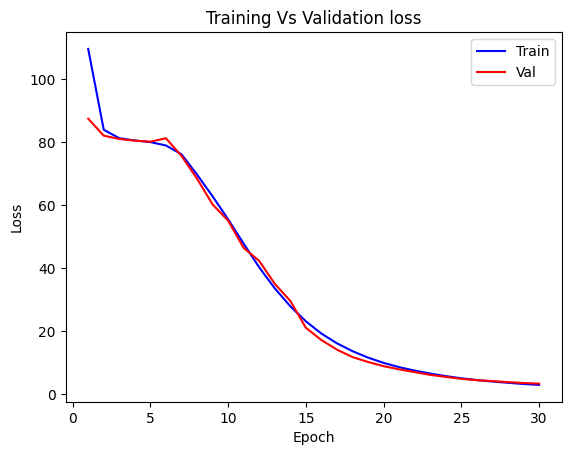

In [ ]:
#plot accuracy and loss
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training Vs Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)
#loss = range(1,len(loss)+1)

plotgraph(epochs, loss, val_loss)


In [ ]:
model.save_weights('/content/drive/MyDrive/Colab_Notebooks/Nega/history4201.hdf5')

In [ ]:
model=model.load_weights('/content/drive/MyDrive/Colab_Notebooks/Nega/C_LSTM_best4802.hdf5')

## Check model performance on validation set

In [ ]:
# please use this one for prediction
y_pred=pred_model.predict(train_x)

out = K.get_value(K.ctc_decode(y_pred[:, :, :], input_length=np.ones(y_pred.shape[0]) * y_pred.shape[1])[0][0])
prd_train = []
for i in range(1800):
    prd_train.append(num_to_label(out[i]))


57/57 [==============================] - 3s 27ms/step


In [ ]:
#please don't use model during testing pred_model is the one
preds = pred_model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1],
                                    greedy=True)[0][0])
prd_valid = []
for i in range(200):
    prd_valid.append(num_to_label(decoded[i]))

7/7 [==============================] - 0s 34ms/step


In [ ]:
print(prd_valid)

['ክች ይገኛሉ። የሥጋ ከብት እርሻ-', 'ሠጡ የሚችሉ የከብት ዝርያዎች', 'ዙ ቁ ያለው የከብት አላት። ነ', 'ኧው። የሚመረተው አሣ ለምግብነ', 'ያን ይሁን እንጊ በአሣ ማምረት', 'ኧማሩትም ጥቂት ሠዎች ናቸው። አ', 'ብለመደረጉ የአሣዎችን እልቂት', 'ጠንካራ ፍለጋ ይጠይቃል። ማእድን', '2 ጥልቀት 3 ጥቃት 4 እውቀት 5', 'ቅድሚያ እነዚህ ነገሮች መጠና', 'ኧጥሮ ነዳጅ የተፈጥሮ ጋዝ ጥጥር', 'ክንያ ወዘተ። 2 በብረት ዩ ሥ', 'ብብሪካ ወደ ምርትነት ይለወጣል።', 'ጭማ የሥክር የዱት የሣሙናን', 'የሥራ እድል ይከፍታሉ። የውጭ ምንዝ', 'ኧቱ በርካታ አለም አቀፍ የኢ', 'ና እሥሜን ነበሩ ከድርጅቱ ዋና', 'ፍ ማህበረሠብ በመባል ይጠራ ይ', 'ኧተባበሩት መንግሥታት ድርጅት ከም', 'ርች ሢሆን በአሁኑ ወቅት የአብ', 'ዋሥትና ሥለሚሠጥ ኢንየሥትመንትን', 'ዲሥፋፋ መርዳት የውጪ ምንዛሪ', 'ጋሉ። ምዕራፍ 2 የሠው ሀይል አ', 'ለበት እንደአፍሪካ ድሃ አህጉር', 'ኧው። በመሆኑም የአፍሪካ ሀገ', 'ጠያይቅም ሀላፊነት የሚሠማው', 'ዋና ዋናዎቹ የሚከተሉት ና', 'ች አኗር አለ ሀብታም ደሃ ይ', 'ህዝቦች መሠረታዊ የሆነ ፍላግ', 'ኧበቀና ተገቢነት ያለው 19።', 'ብቻ እንደሆነ ካደገና በማደ', 'ረት በመሥጠት 1994 አ።ም ጀምር', 'ላይ ይገኛል። አዲሡ የትምህርት ብ', 'ለው በአንጻሩ ደግሞ በህብረተ', 'ቀም ላይ ከፍተኛ የሆነ አሉት', 'ልሥከተል ለተጨማሪ በጊዜው ክ', 'ሙ ቀርተዋል። ምዕራፍ 3 የኤድሥ', 'ዝኔታን የሚፈጥር ቫይረሥ ነው።', 'ምፃረቃል የተወሠደው አሙየር', 'የተለያዩ የበሽታ አይነቶች', 'በቫይረሡ ከተጠቁ እናቶች የ', 'ው የሚደርሡበት ችግሮች በግለሠ', 'ፍረሥ ወዘተ በግለሠቡ ኢኮን', 'ኧሆነና በፍቃደኝነት ላይ የተ'

In [ ]:
y_true = valid_original_text   #Character Error Rate
correct_char = 0
total_char = 0
correct_seq = 0
corect_char=0
error_chr=0
error_seq=0
pp=[]
pt=[]
gt=[]
rt=[]
err=0
for i in range(200):
    pr = prd_valid[i]
    tr = valid_original_text[i]
    total_char += len(tr)
    #err += Levenshtein.distance(pr, tr)
    if pr == tr :
      correct_seq += 1
    else:
      gt.append(pr)
      rt.append(tr)
      error_seq+=1
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char+= 1
        else:
          pp.append(pr[j])
          pt.append(tr[j])
    for j in range(min(len(pr), len(tr))):
        if pr[j] == tr[j]:
          corect_char+= 1
        else:
          error_chr+=1

print(gt)
print(rt)
print('Correct characters Rate : %.2f%%' %(corect_char*100/total_char))
print('Charcter Error Rate : %.2f%%' %(error_chr*100/total_char))
print('Correct Sequence Rate : %.2f%%' %(correct_seq*100/200))
print('Seqence Error Rate : %.2f%%' %(error_seq*100/200))

['ያን ይሁን እንጊ በአሣ ማምረት', 'ክንያ ወዘተ። 2 በብረት ዩ ሥ', 'ጭማ የሥክር የዱት የሣሙናን', 'ና እሥሜን ነበሩ ከድርጅቱ ዋና', 'ዋሥትና ሥለሚሠጥ ኢንየሥትመንትን', 'ች አኗር አለ ሀብታም ደሃ ይ', 'ላይ ይገኛል። አዲሡ የትምህርት ብ', 'ልሥከተል ለተጨማሪ በጊዜው ክ', 'ምፃረቃል የተወሠደው አሙየር', 'ንዲቀበሉና ተፅዕኖዎችን እንዲቅ', 'ኧቅም የሚፈታተን ማና ይፈጥራል', 'ግብ ምርቶች ማምረት ሥለሚገፋዱ', 'ድሥ ማንውም ቫይረሡ የተላለፍ', 'ድዊ ግታ ነው። ምዕራፍ 4 ዋና', 'ም መሣሪያ ሢፈጥሩ ነባሩን', 'ንን ሊያሥገኝ ችሏል። ማርኮኒ ባ', 'ውያዎችና በብዙ ሚህ ኪሜ ርቀ', 'ዳጅ ጀምሥ ዋት የሚባል አርፓ', 'ብደቶችን በዎፋ በባቡርና በ', 'ከተሉት ወሣኝ ግኝቶች 1 ነበ', 'ነልካም ሥነ-ምግባር ራሥን የመሩ', 'ስም ትውልድ ለማቆየት በዋሻዎች', 'ሀገር ባደረገው ሙከራ ለመጅ', 'ኧመብረር ምት ከተጠናወታቸው', 'ህድቸውም ከነሡ በፊት የተደር', 'ሙከራ የተጀመረ በራሪ እድግድ', 'ክች ዊልቨር ራይት በ191 እሊእ', 'ና በአምክዊ ተግባራት ፥።', 'የሚገባውን ሥነ-ምግባር በግልልኝ ይ', 'ስሞችን ብርና ተግባር እንዲጠብቁ', 'ር፥ በ18 አ።ም የተወለደ34።', 'ሞተር ሀይል ይንቀሣቀሣሉ የሠ', 'እንፋሎት ሀይል የሚንቀሣቀሥ አ', 'ን የሚሠራ እንህን በመፈልሠፍ ል', 'ትሪክ የሚሠሩ ተሽከርክ ሪዎችም', 'ኧ አ።አ ድረሥ የባቡር ሃድድ ል', 'ምት ሢሆን ዋና ዋናዎቹ የሚክ', 'እርነት ለመማር ሠበብ ሢፈልጉ', 'ልም መገደል ላንደኛው አለም', 'ል መንግሥት እንዲፈቅድ የሚጠይቅ ን', 'ይማኖት  የሮርቶዱክሥ እምነት ተ', 'ሌድው ጦርነት የተፈለገውን ድል', 'የማኑ መርከቦችን ባህር ውሥጥ በ', 'ኧ2 አቅጣ3 በ1 ጊዜ ጦርነት', 

In [ ]:
error_seq

81

In [ ]:
train_error_seq=0                               #Charcter Error Rate Calculation
Valid_error_seq=0
Test_error_seq=0
total_train_char=0
total_valid_char=0
total_Test_char=0
st=[]
pd=[]
pv=[]
vt=[]
im=[]
train_error=0
valid_error=0
test_error=0
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]
for i in range (1800):                #Character Error Rate for Train Data Set
    pr = prd_train[i]
    tr = train_original_text[i]
    total_train_char+= len(train_original_text[i])
    if pr != tr:
      train_error_seq+= 1
      st.append(tr)
      pd.append(pr)
    train_error+=levenshteinDistance(train_original_text[i], prd_train[i])
for i in range (200):                  #Character Error Rate for Validation Data Set
    pr = prd_valid[i]
    rrr=valid[i]
    tr = valid_original_text[i]
    total_valid_char += len(valid_original_text[i])
    if pr != tr:
      im.append(rrr)
      pv.append(pr)
      vt.append(tr)

      Valid_error_seq+= 1
    valid_error+=levenshteinDistance(valid_original_text[i], prd_valid[i])
print('Train Set Character Error Rate : %.2f%%' %(train_error*100/total_train_char))
print('Train Set Sequnce Error Rate : %.2f%%' %(train_error_seq*100/1800))
print('Valid Set Character Error Rate : %.2f%%' %(valid_error*100/total_valid_char))
print('Valid Set Sequnce Error Rate : %.2f%%' %(Valid_error_seq*100/200))

Train Set Character Error Rate : 1.29%
Train Set Sequnce Error Rate : 19.56%
Valid Set Character Error Rate : 2.97%
Valid Set Sequnce Error Rate : 40.50%


In [ ]:
for i in range(len(pv)):
  print(pv[i]+"\n"+vt[i])

len(pd)

ያን ይሁን እንጊ በአሣ ማምረት
ያን ይሁን እንጂ በአሣ ማምረት
ክንያ ወዘተ። 2 በብረት ዩ ሥ
ክንዥያ ወዘተ። 2 በብረት ዩ ሥ
ጭማ የሥክር የዱት የሣሙናን
ጭማ የሥኳር የዱቄት የሣሙናን
ና እሥሜን ነበሩ ከድርጅቱ ዋና
ና እሥፔን ነበሩ ከድርጂቱ ዋና
ዋሥትና ሥለሚሠጥ ኢንየሥትመንትን
ዋሥትና ሥለሚሠጥ ኢንቨሥትመንትን
ች አኗር አለ ሀብታም ደሃ ይ
ች አኗኗር አለ ሀብታም ደሃ ይ
ላይ ይገኛል። አዲሡ የትምህርት ብ
ላይ ይገኛል። አዲሡ የትምህርት ሥ
ልሥከተል ለተጨማሪ በጊዜው ክ
ሕሥከተል ለተጨማሪ በጊዜው ክ
ምፃረቃል የተወሠደው አሙየር
ምፃረቃል የተወሠደው አሟየር
ንዲቀበሉና ተፅዕኖዎችን እንዲቅ
ንዲቀበሉና ተጽዕኖዎችን እንዲቅ
ኧቅም የሚፈታተን ማና ይፈጥራል
ኧቅም የሚፈታተን ጫና ይፈጥራል
ግብ ምርቶች ማምረት ሥለሚገፋዱ
ግብ ምርቶች ማምረት ሥለሚገፋፉ
ድሥ ማንውም ቫይረሡ የተላለፍ
ድሥ ማንኜውም ቫይረሡ የተላለፍ
ድዊ ግታ ነው። ምዕራፍ 4 ዋና
ድዊ ግዴታ ነው። ምዕራፍ 4 ዋና
ም መሣሪያ ሢፈጥሩ ነባሩን
ም መሣሪያ ሢፈጥሩ ኽነባሩን
ንን ሊያሥገኝ ችሏል። ማርኮኒ ባ
ፕን ሊያሥገኝ ችሏል። ማርኮኒ ባ
ውያዎችና በብዙ ሚህ ኪሜ ርቀ
ውያዎችና በብዙ ሺህ ኪ።ሜ ርቀ
ዳጅ ጀምሥ ዋት የሚባል አርፓ
ዳጅ ጀምሥ ዋት የሚባል አውሮፓ
ብደቶችን በዎፋ በባቡርና በ
ብደቶችን በዎፍጮ በባቡርና በ
ከተሉት ወሣኝ ግኝቶች 1 ነበ
ከተሉት ወሣኝ ግኝቶች 1ኡ ነበ
ነልካም ሥነ-ምግባር ራሥን የመሩ
መልካም ሥነ-ምግባር ራሥን የመሩ
ስም ትውልድ ለማቆየት በዋሻዎች
ስም ትውልድ ለማቆየት በዋሻወች
ሀገር ባደረገው ሙከራ ለመጅ
ሀገር ባደረገው ሙከራ ለምጅ
ኧመብረር ምት ከተጠናወታቸው
ኧመብረር ምኞት ከተጠናወታቸው
ህድቸውም ከነሡ በፊት የተደር
ህዷቸውም ከነሱ በፊት የተደር
ሙከራ የተጀመረ በራሪ እድግድ


352

In [ ]:
plt.figure(figsize=(15, 20)) #Sample Prediction
for i in range(20):
    ax = plt.subplot(10, 2, i+1)
    plt.imshow(im[i], cmap='gray')
    plt.axis('on')
plt.subplots_adjust(wspace=0.7, hspace=-0.2)

## Some predictions on test set

In [ ]:
plt.figure(figsize=(10, 40)) #Sample Prediction
for i in range(30):
    ax = plt.subplot(30, 1, i+1)
    image = im[i]
    #plt.title(print(prd_train[i]))
    #plt.title(print(pv[i] + "     " + vt[i]))
    plt.imshow(image, cmap='gray')
    plt.axis('on')
plt.subplots_adjust(wspace=0.4, hspace=-0.01)

In [ ]:
#Test Set Prediction Implementation
img=[]
test_img_list = sorted(glob.glob('/content/drive/MyDrive/Colab_Notebooks/Nega/test-dataset/test-images/*.PNG'))
for i, img_path in enumerate(test_img_list):
  ims=cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  th2 = cv2.adaptiveThreshold(ims,170,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,35,25)
  im=im_resize(th2)
  image = im/255.
  img.append(image)

test_x = np.asarray(img).reshape(-1, 48, 256, 1) #(16384,1)
preds = pred_model.predict(test_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1],
                                    greedy=True)[0][0])
prd_test = []
for i in range(100):
    prd_test.append(num_to_label(decoded[i]))

4/4 [==============================] - 1s 233ms/step


In [ ]:
prd_test

['አቀፍ ፍርድ ቤት 6 የድርጅቱ 64ድ',
 'እፈት ቤት ጠቅላላ ጉባኤው አብ',
 'ብብ አገሮችን በሙሉ የሚያካት',
 'ት ነው። የድርጅቱ ከፍተኛው አካ',
 'ል ነው። አባል ሀገሮች ተወካይ',
 'ካ በየ አም።ቱ ኒውርክ ከተማ',
 'ድርጅቱ ህንያ ውሥጥ እየተገናኙኝ',
 'ሠባ ያደርጋሉ። እየተከራክ',
 'ኧሩም ውሣኔዎችን ያሣልፋሉ። መ',
 'መሪያዎችን ይሠጣሉ። ይሠጣሉ።',
 'አለም አቀፍ ህጎችን ይደነግጋሉ',
 'ባጀትም ይመድባሉ። የፀጥታ ጥበ',
 'ነት ፓርት ድል ተጎናፅ በር',
 'ቀቀ ሢሆን 5- ቋሚ አባል',
 'ክት ናቸው። እነሡም፥ አሜሪካ ር',
 'ሢያ እንግሊዝ ፈረንሣይና ቻይን',
 'ክ ሢሆኑ ድምፅን በድምፅ የመሻር',
 'ሥልጣን አላቸው። አ191 ደግሞ',
 'ጊዜያዊ አባላት ሢሆኑ በየ',
 ' አመቱ በጠቅላላ ጉባኤ ክ',
 'ባብ ሀገሮች መካከል የሚም',
 'ዴግ፥ ናው የምክር ቤቱ ዋና',
 'ተግባር የአለምን ሠላምና የጥት',
 'ብ መግበግ ነው። አሥግ ነገር ሥ',
 '5ህ በወታደራዊ ሀይል እሥክ',
 'ብ መገቀም ይደርሣል። የኢኮኖም',
 'ሥና የማህበራዊ ጉዳይ ምክር ቤ',
 'ት በጠቅላላ ጉባኤዳ 58 አባል',
 'መድ በልዩ ልዩ ውሃ አካላቶ።',
 'ውሥጥ የተለያዩ የአሣ ይርያን',
 'ች ይገኛሉ ለምግብነት የሚውሉት',
 'የተወሠኑ ይነቶ የሚግ፥',
 'በት አከባቢዎች አሉ። አሣ ብ',
 'ኧምት የሚገቸው የድ',
 'ች 1። በሠሜን ምሥራቅ አትላንት',
 'ክ 2 የሠሜን ምዕራብ አትላንቲ',
 'ክ 3። ከሁሉም በላይ በሠሜን',
 'ምዕራብ ፓሥክ 4 እንዱ-ፓፊክ',
 '5 መካከለኛው ፓሥፊክ ናቸው።',
 'ለአሣ መራት በጣም ቀእቃ1',
 'ህበጣም ሞቃት ሥፍራዎች አመቺ',
 'አይደሉም ለመሆኑም መካከለኝ',
 'ብ የሙቀት ክልል አካባቢዎች ከ',
 'ፍተኛ ክ

In [ ]:
tast_y = []
test_input_len = []
test_label_len = []
test_original_text = []
ima=[]
prt=[]
grt=[]
total_test_char=0
test_error=0
test_error_seq=0
with open('/content/drive/MyDrive/Colab_Notebooks/Nega/test-dataset/test-label.txt', encoding="utf-8") as f:
    contents = f.readlines()[0:200]

lines = [line.strip() for line in contents]
for i in range(len(lines)):
  test_original_text.append(lines[i])

def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

for i in range (100):                  #Character Error Rate for Validation Data Set
    pt = prd_test[i]
    rrr =img[i]
    tr = test_original_text[i]
    total_test_char += len(test_original_text[i])
    if pt != tr:
      ima.append(rrr)
      prt.append(pt)
      grt.append(tr)
      test_error_seq+= 1
    test_error+=levenshteinDistance(test_original_text[i], prd_test[i])
print('Test Set Character Error Rate : %.2f%%' %(test_error*100/total_test_char))
print('Test Set Sequnce Error Rate : %.2f%%' %(test_error_seq*100/100))

Test Set Character Error Rate : 10.58%
Test Set Sequnce Error Rate : 83.00%
